In [1]:
from pathlib import Path

# Get the current working directory as a Path object
current_path = Path.cwd()
home_folder = 'evan_home'

# Traverse up the directory tree until you find the target folder
for parent in [current_path] + list(current_path.parents):
    if parent.name == home_folder:
        home_path = parent
        break
else:
    raise ValueError(f"Folder '{home_folder}' not found in the current working directory.")

print("Home Path:", home_path)
source_code_dir = home_path / 'Source_code'
dataset_dir = home_path / 'Dataset'


Home Path: c:\Users\evanlee\Documents\Bmi_NAS_evan\evan_home


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scanpy as sc
import os
import copy
import pickle

In [3]:
# Hao L2 celltypes
# types = ['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']
types = ['ASDC', 'B_intermediate', 'B_memory', 'B_naive', 'CD14_Mono', 'CD16_Mono', 'CD4_CTL', 'CD4_Naive', 'CD4_Proliferating', 'CD4_TCM', 'CD4_TEM', 'CD8_Naive', 'CD8_Proliferating', 'CD8_TCM', 'CD8_TEM', 'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK_CD56bright', 'NK_Proliferating', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2', 'dnT', 'gdT', 'pDC']

## Read PreLect features

In [4]:
import os
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level1\feature_selection_k3")
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch_noZ/Level2/feature_selection_k3')
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level2/feature_selection_k3')

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue

In [5]:
features_dict.keys()

dict_keys(['ASDC', 'B_intermediate', 'B_memory', 'B_naive', 'CD14_Mono', 'CD16_Mono', 'CD4_CTL', 'CD4_Naive', 'CD4_Proliferating', 'CD4_TCM', 'CD4_TEM', 'CD8_Naive', 'CD8_Proliferating', 'CD8_TCM', 'CD8_TEM', 'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK_CD56bright', 'NK_Proliferating', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2', 'dnT', 'gdT', 'pDC'])

In [6]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
ASDC,47,25
B_intermediate,96,49
B_memory,170,90
B_naive,9,6
CD14_Mono,29,16
CD16_Mono,37,17
CD4_CTL,122,45
CD4_Naive,730,393
CD4_Proliferating,70,35
CD4_TCM,247,133


## Read Stuart dataset

In [7]:
import scanpy as sc
# bmcite = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\Stuart_bm\Stuart_bmcite_RNAassay_original.h5ad")
# bmcite = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/Stuart_bm/Stuart_bmcite_RNAassay_original.h5ad')
bmcite = sc.read_h5ad(dataset_dir / 'Stuart_bm/Stuart_bmcite_RNAassay_original.h5ad')
bmcite.shape

(30672, 17009)

In [9]:
# PreLect genes used to train LR model
celltype = 'ASDC'
train_genes = features_dict[celltype]['Gene'].tolist() 
query_genes = bmcite.var_names.tolist()
common_genes = list(set(train_genes) & set(query_genes))

# Create a full matrix for query data, initializing with zeros for missing genes
X_query_full = np.zeros((bmcite.shape[0], len(train_genes)))
# Fill in the values for the common genes
for i, gene in enumerate(train_genes):
    if gene in common_genes:
        X_query_full[:, i] = bmcite[:, gene].X.toarray().flatten()
    else:
        print('Missing', gene)

X_query_full.shape

(30672, 47)

In [10]:
def predict_celltype_w_symbol(LR_model, query_adata, features_dict, celltype):
    # PreLect features (symbol)
    train_genes = features_dict[celltype]['Gene'].tolist()
    print('Train genes (top10):', train_genes[:10])

    # PreLect features (symbol) have 9 intersectoin with Zheng (symbol)
    query_genes = query_adata.var_names.tolist()
    common_genes = list(set(train_genes) & set(query_genes))
    missing_genes = list(set(train_genes) - set(query_genes))
    print('No. common genes:', len(common_genes))
    print('Common genes (top10):', common_genes[:10])
    print('No. missing genes:', len(missing_genes))
    print('Missing genes:', missing_genes)

    # Create a full matrix for query data, initializing with zeros for missing genes
    X_query_full = np.zeros((query_adata.shape[0], len(train_genes)))
    # Fill in the values for the common genes
    for i, gene in enumerate(train_genes):
        if gene in common_genes:
            X_query_full[:, i] = query_adata[:, gene].X.toarray().flatten()

    # predict on query dataset
    y_query_pred = LR_model.predict(X_query_full)
    print('Prediction = 1:', sum(y_query_pred == 1))  # predict celltype 的有幾個

    # Get the probability of individual cell predicting as the positive class
    y_query_prob = LR_model.predict_proba(X_query_full)[:, 1]  # Probability for the positive class (class 1)
    print('Probability > 0.5:', sum(y_query_prob > 0.5))  # >0.5: predict celltype, <0.5: predict not celltype

    return y_query_pred, y_query_prob

In [ ]:
# os.chdir(r'C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level1\LR_likelihood\LR_model')
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch_noZ/Level2/LR_likelihood/LR_models')
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level2/LR_likelihood/LR_models')

celltype = 'ASDC'
with open(f'LRclassifier_{celltype}_l2.pkl', 'rb') as f:
    lr_model = pickle.load(f)

y_pred_B, y_prob_B = predict_celltype_w_symbol(lr_model, bmcite, features_dict, celltype)

Train genes (top10): ['CD52', 'S100A10', 'S100A9', 'PTPRC', 'RPL32', 'CCDC50', 'PLAC8', 'RPL34', 'DAB2', 'SOX4']
No. common genes: 47
Common genes (top10): ['PLAC8', 'HLA-DPA1', 'RPLP1', 'RPL34', 'LILRA4', 'MT-CO2', 'IRF8', 'CCDC50', 'PLD4', 'S100A10']
No. missing genes: 0
Missing genes: []
Prediction = 1: 32
Probability > 0.5: 32


In [12]:
prediction_dict = {}
likelihood_dict = {}
skipped = ['Doublet', 'Eryth', 'Platelet']

for celltype in types:
    print(celltype, '=====================')
    if celltype in skipped:
        print('Skipping', celltype)
        continue
    with open(f'LRclassifier_{celltype}_l2.pkl', 'rb') as f:
        lr_model = pickle.load(f)
    
    y_pred_celltype, y_prob_celltype = predict_celltype_w_symbol(lr_model, bmcite, features_dict, celltype)
    prediction_dict[celltype] = y_pred_celltype
    likelihood_dict[celltype] = y_prob_celltype

ASDC =====================
Train genes (top10): ['CD52', 'S100A10', 'S100A9', 'PTPRC', 'RPL32', 'CCDC50', 'PLAC8', 'RPL34', 'DAB2', 'SOX4']
No. common genes: 47
Common genes (top10): ['PLAC8', 'HLA-DPA1', 'RPLP1', 'RPL34', 'LILRA4', 'MT-CO2', 'IRF8', 'CCDC50', 'PLD4', 'S100A10']
No. missing genes: 0
Missing genes: []
Prediction = 1: 32
Probability > 0.5: 32
B_intermediate =====================
Train genes (top10): ['SMAP2', 'JAK1', 'TXNIP', 'PLEKHO1', 'S100A10', 'S100A9', 'S100A4', 'FCRL3', 'FCRL2', 'TAGLN2']
No. common genes: 95
Common genes (top10): ['IGHD', 'CXXC5', 'DDX24', 'MT-CO2', 'MIS18BP1', 'SUB1', 'TCF4', 'SEPT6', 'EMP3', 'TMBIM6']
No. missing genes: 1
Missing genes: ['LINC01857']
Prediction = 1: 271
Probability > 0.5: 271
B_memory =====================
Train genes (top10): ['SH3BGRL3', 'MARCKSL1', 'SMAP2', 'UQCRH', 'JUN', 'LINC01781', 'CD53', 'TXNIP', 'PLEKHO1', 'CTSS']
No. common genes: 168
Common genes (top10): ['EEF1A1', 'PPDPF', 'CPNE5', 'RPS29', 'RAN', 'PRRC2C', 'RPS19'

In [13]:
prediction_df = pd.DataFrame(prediction_dict)
likelihood_df = pd.DataFrame(likelihood_dict)
prediction_df.head()

,ASDC,B_intermediate,B_memory,B_naive,CD14_Mono,CD16_Mono,CD4_CTL,CD4_Naive,CD4_Proliferating,CD4_TCM,...,NK,NK_CD56bright,NK_Proliferating,Plasmablast,Treg,cDC1,cDC2,dnT,gdT,pDC
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# 同時被多個 one-vs-rest classifier 分類為某類別的細胞數有幾個 (prediction = 1 in multiple celltypes)
# prediction_df.sum(axis=1).max()  # 4
num = [4, 3, 2]
for i in num:
    print('=====', i, '=====')
    # print(prediction_df.loc[prediction_df.sum(axis=1) == i, :])
    print(prediction_df.loc[prediction_df.sum(axis=1) == i, :].shape)

===== 4 =====
(12, 28)
===== 3 =====
(317, 28)
===== 2 =====
(3905, 28)


In [15]:
likelihood_df.head()

,ASDC,B_intermediate,B_memory,B_naive,CD14_Mono,CD16_Mono,CD4_CTL,CD4_Naive,CD4_Proliferating,CD4_TCM,...,NK,NK_CD56bright,NK_Proliferating,Plasmablast,Treg,cDC1,cDC2,dnT,gdT,pDC
0,3.839392e-09,5.281876e-05,0.000231,3.859655e-05,0.000002,1.191837e-05,5.503583e-07,0.002517,9.472843e-04,0.000606,...,0.000002,5.688004e-04,3.522637e-04,1.616050e-06,0.000358,1.964932e-07,2.943487e-05,0.001087,0.000124,0.000006
1,4.783159e-09,1.537271e-05,0.097065,9.355212e-07,0.000001,9.732743e-08,5.574470e-04,0.920287,3.959816e-05,0.017807,...,0.000831,6.736964e-07,3.919982e-09,7.002075e-08,0.000027,4.704349e-07,3.406926e-08,0.000002,0.000316,0.000004
2,2.767475e-11,2.190240e-04,0.000599,6.003153e-06,0.000003,1.773350e-07,6.099565e-05,0.272334,1.587435e-05,0.107343,...,0.000042,3.763995e-06,3.177098e-10,6.241265e-07,0.928359,3.905310e-07,4.614748e-09,0.000779,0.000031,0.000007
3,8.338631e-11,2.551095e-05,0.000283,1.746342e-06,0.000001,1.665545e-08,3.323813e-03,0.082570,6.818176e-06,0.628304,...,0.000018,2.056164e-06,5.333776e-10,1.442366e-06,0.001091,3.010307e-08,4.416918e-09,0.000022,0.000287,0.000003
4,1.495617e-10,2.648409e-07,0.000023,1.783472e-05,0.946326,1.933774e-06,1.085674e-09,0.000004,3.645416e-08,0.000255,...,0.000502,1.230439e-07,3.973969e-10,4.250865e-08,0.000008,8.680287e-11,9.617147e-05,0.000004,0.000001,0.000023


In [ ]:
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/Stuart_bm_annotate/Predict_w_Hao_LR')
os.chdir(source_code_dir / 'Stuart_bm_annotate/Predict_w_Hao_LR')
likelihood_df.to_csv('PreLect_LR_L2_prediction_likelihood.csv')

In [16]:
# Assign predicted celltype with max likelihood
largest_values = []
largest_columns = []
assignments = []
for index, row in likelihood_df.iterrows():
    # find largest value and their corresponding columns
    largest_value = row.max()
    largest_column = row.idxmax()
    largest_values.append(largest_value)
    largest_columns.append(largest_column)

    assign = largest_column
    assignments.append(assign)

bmcite.obs['Pred_LR_L2'] = assignments
bmcite.obs['LR_likelihood_l2'] = largest_values
bmcite.obs.head()

,nCount_RNA,nFeature_RNA,nCount_ADT,nFeature_ADT,lane,donor,celltype.l1,celltype.l2,RNA.weight,Pred_LR_L2,LR_likelihood_l2
a_AAACCTGAGCTTATCG-1,7546.0,2136,1350.0,25,HumanHTO4,batch1,Progenitor cells,Prog_RBC,0.482701,HSPC,0.180450
a_AAACCTGAGGTGGGTT-1,1029.0,437,2970.0,25,HumanHTO1,batch1,T cell,gdT,0.241789,CD4_Naive,0.920287
a_AAACCTGAGTACATGA-1,1111.0,429,2474.0,23,HumanHTO5,batch1,T cell,CD4 Naive,0.507714,Treg,0.928359
a_AAACCTGCAAACCTAC-1,2741.0,851,4799.0,25,HumanHTO3,batch1,T cell,CD4 Memory,0.431308,CD4_TEM,0.777593
a_AAACCTGCAAGGTGTG-1,2099.0,843,5434.0,25,HumanHTO2,batch1,Mono/DC,CD14 Mono,0.568508,CD14_Mono,0.946326


## Prediction confusion matrix

In [17]:
# BMcite true L2 labels
bm_l2_to_converted_A = {
'Naive B': 'B',
'Memory B': 'B',
'CD4 Naive': 'CD4_T',
'CD4 Memory': 'CD4_T', # 'CD4_TEM', 'CD4_TCM',
'CD8 Naive': 'CD8_T',
'CD8 Effector_1': 'CD8_T',
'CD8 Effector_2': 'CD8_T',
'CD8 Memory_1': 'CD8_T',
'CD8 Memory_2': 'CD8_T',
'gdT': 'other_T',
'Treg': 'other_T',
'MAIT': 'other_T',
'cDC2': 'DC',
'pDC': 'DC',
'CD14 Mono': 'Mono',
'CD16 Mono': 'Mono',
'NK': 'NK',
'CD56 bright NK': 'NK',
'Plasmablast': 'other',
'HSC': 'other',  # (Hematopeitic stem and progenitor cell)
'GMP': 'other',  # (granulocyte macrophage progenitor)
'LMPP': 'other', # (Lympho-myeloid primed progenitor)
'Prog_RBC': 'other',
'Prog_B 1': 'other',
'Prog_B 2': 'other',
'Prog_DC': 'other',
'Prog_Mk': 'other'  # (megakaryocyte)
}

bm_l2_to_converted_B = {
'Naive B': 'B_naive',
'Memory B': 'B_memory',
'CD4 Naive': 'CD4_Naive',
'CD4 Memory': 'CD4 Memory', # 'CD4_TEM', 'CD4_TCM',
'CD8 Naive': 'CD8_Naive',
'CD8 Effector_1': 'CD8_TEM',
'CD8 Effector_2': 'CD8_TEM',
'CD8 Memory_1': 'CD8_TCM',
'CD8 Memory_2': 'CD8_TCM',
'gdT': 'gdT',
'Treg': 'Treg',
'MAIT': 'MAIT',
'cDC2': 'cDC',
'pDC': 'pDC',
'CD14 Mono': 'CD14_Mono',
'CD16 Mono': 'CD16_Mono',
'NK': 'NK',
'CD56 bright NK': 'NK_CD56bright',
'Plasmablast': 'Plasmablast',
'HSC': 'Progenitor cells',  # (Hematopeitic stem and progenitor cell)
'GMP': 'Progenitor cells',  # (granulocyte macrophage progenitor)
'LMPP': 'Progenitor cells', # (Lympho-myeloid primed progenitor)
'Prog_RBC': 'Progenitor cells',
'Prog_B 1': 'Progenitor cells',
'Prog_B 2': 'Progenitor cells',
'Prog_DC': 'Progenitor cells',
'Prog_Mk': 'Progenitor cells'  # (megakaryocyte)
}

In [18]:
hao_l2_to_converted = {
    'CD4_TCM': 'CD4 Memory', 
    'CD4_TEM': 'CD4 Memory', 
    'cDC1': 'cDC', 
    'cDC2': 'cDC', 
    'HSPC': 'Progenitor cells'
}

In [19]:

for cell in bmcite.obs_names:
    # Convert true L2 bmcite labels
    if bmcite.obs.loc[cell, 'celltype.l2'] in bm_l2_to_converted_A:
        bmcite.obs.loc[cell, 'true_L2_converted_A'] = bm_l2_to_converted_A[bmcite.obs.loc[cell, 'celltype.l2']]
    else:
        pass
    if bmcite.obs.loc[cell, 'celltype.l2'] in bm_l2_to_converted_B:
        bmcite.obs.loc[cell, 'true_L2_converted_B'] = bm_l2_to_converted_B[bmcite.obs.loc[cell, 'celltype.l2']]
    else:
        pass

    # Convert PreLect predicted labels (from Hao)
    if bmcite.obs.loc[cell, 'Pred_LR_L2'] in hao_l2_to_converted:
        bmcite.obs.loc[cell, 'Pred_converted'] = hao_l2_to_converted[bmcite.obs.loc[cell, 'Pred_LR_L2']]
    else:
        bmcite.obs.loc[cell, 'Pred_converted'] = bmcite.obs.loc[cell, 'Pred_LR_L2']
bmcite.obs.head()

,nCount_RNA,nFeature_RNA,nCount_ADT,nFeature_ADT,lane,donor,celltype.l1,celltype.l2,RNA.weight,Pred_LR_L2,LR_likelihood_l2,true_L2_converted_A,true_L2_converted_B,Pred_converted
a_AAACCTGAGCTTATCG-1,7546.0,2136,1350.0,25,HumanHTO4,batch1,Progenitor cells,Prog_RBC,0.482701,HSPC,0.180450,other,Progenitor cells,Progenitor cells
a_AAACCTGAGGTGGGTT-1,1029.0,437,2970.0,25,HumanHTO1,batch1,T cell,gdT,0.241789,CD4_Naive,0.920287,other_T,gdT,CD4_Naive
a_AAACCTGAGTACATGA-1,1111.0,429,2474.0,23,HumanHTO5,batch1,T cell,CD4 Naive,0.507714,Treg,0.928359,CD4_T,CD4_Naive,Treg
a_AAACCTGCAAACCTAC-1,2741.0,851,4799.0,25,HumanHTO3,batch1,T cell,CD4 Memory,0.431308,CD4_TEM,0.777593,CD4_T,CD4 Memory,CD4 Memory
a_AAACCTGCAAGGTGTG-1,2099.0,843,5434.0,25,HumanHTO2,batch1,Mono/DC,CD14 Mono,0.568508,CD14_Mono,0.946326,Mono,CD14_Mono,CD14_Mono


In [ ]:
# os.chdir(r'C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\Stuart_bm_annotate\Predict_w_Hao_LR')
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/Stuart_bm_annotate/Predict_w_Hao_LR')
os.chdir(source_code_dir / 'Stuart_bm_annotate/Predict_w_Hao_LR')
bmcite.obs.to_csv('PreLect_LR_L2_prediction_obs.csv')

In [34]:
# true_labels = bmcite.obs['celltype.l2']
true_labels = bmcite.obs['true_L2_converted_B']
# predicted_labels = bmcite.obs['Pred_LR_L2']
predicted_labels = bmcite.obs['Pred_converted']

cm = pd.crosstab(true_labels, predicted_labels, rownames=['True'], colnames=['PreLect LR model predicted'], margins=False)
print(cm.index)
print(cm.columns)

Index(['B_memory', 'B_naive', 'CD14_Mono', 'CD16_Mono', 'CD4 Memory',
       'CD4_Naive', 'CD8_Naive', 'CD8_TCM', 'CD8_TEM', 'MAIT', 'NK',
       'NK_CD56bright', 'Plasmablast', 'Progenitor cells', 'Treg', 'cDC',
       'gdT', 'pDC'],
      dtype='object', name='True')
Index(['ASDC', 'B_intermediate', 'B_memory', 'B_naive', 'CD14_Mono',
       'CD16_Mono', 'CD4 Memory', 'CD4_CTL', 'CD4_Naive', 'CD4_Proliferating',
       'CD8_Naive', 'CD8_Proliferating', 'CD8_TCM', 'CD8_TEM', 'ILC', 'MAIT',
       'NK', 'NK_CD56bright', 'NK_Proliferating', 'Plasmablast',
       'Progenitor cells', 'Treg', 'cDC', 'dnT', 'gdT', 'pDC'],
      dtype='object', name='PreLect LR model predicted')


In [35]:
row_order = ['B_memory', 'B_naive', 
             'CD4 Memory', 'CD4_Naive', 
             'CD8_Naive', 'CD8_TCM', 'CD8_TEM', 
             'MAIT', 'gdT', 'Treg', 
             'cDC', 'pDC', 
             'CD14_Mono', 'CD16_Mono', 
             'NK', 'NK_CD56bright', 
             'Plasmablast', 'Progenitor cells']
col_order = ['B_memory', 'B_naive', 'B_intermediate', 
             'CD4 Memory', 'CD4_Naive', 'CD4_Proliferating', 'CD4_CTL', 
             'CD8_Naive', 'CD8_TCM', 'CD8_TEM', 'CD8_Proliferating', 
             'MAIT', 'gdT', 'Treg', 'dnT', 
             'cDC', 'pDC', 'ASDC', 
             'CD14_Mono', 'CD16_Mono', 
             'NK', 'NK_CD56bright', 'NK_Proliferating', 
             'Plasmablast', 'Progenitor cells', 
             'ILC']
cm = cm.reindex(row_order, axis=0)
cm = cm.reindex(col_order, axis=1)
cm

PreLect LR model predicted,B_memory,B_naive,B_intermediate,CD4 Memory,CD4_Naive,CD4_Proliferating,CD4_CTL,CD8_Naive,CD8_TCM,CD8_TEM,...,pDC,ASDC,CD14_Mono,CD16_Mono,NK,NK_CD56bright,NK_Proliferating,Plasmablast,Progenitor cells,ILC
True,,,,,,,,,,,,,,,,,,,,,
B_memory,1280,45,238,7,11,0,0,2,1,1,...,1,0,0,0,1,0,0,0,0,0
B_naive,497,1256,44,2,32,0,0,0,1,0,...,2,0,2,0,0,1,0,0,0,0
CD4 Memory,22,0,0,2570,212,3,22,2,133,35,...,0,0,0,0,0,1,0,0,0,2
CD4_Naive,15,0,0,200,3907,0,1,18,6,3,...,0,0,0,0,0,0,0,0,0,0
CD8_Naive,29,0,0,100,713,0,1,2616,112,60,...,1,0,1,0,0,1,0,0,0,0
CD8_TCM,6,0,1,46,7,0,40,12,211,594,...,0,0,1,0,19,0,1,0,0,0
CD8_TEM,3,1,1,2,5,0,16,1,7,762,...,0,0,2,0,17,3,0,0,0,0
MAIT,6,0,0,51,2,0,10,2,11,27,...,0,0,1,0,19,0,0,0,0,0
gdT,1,0,0,14,2,0,24,1,2,18,...,0,0,0,0,21,1,0,0,0,1


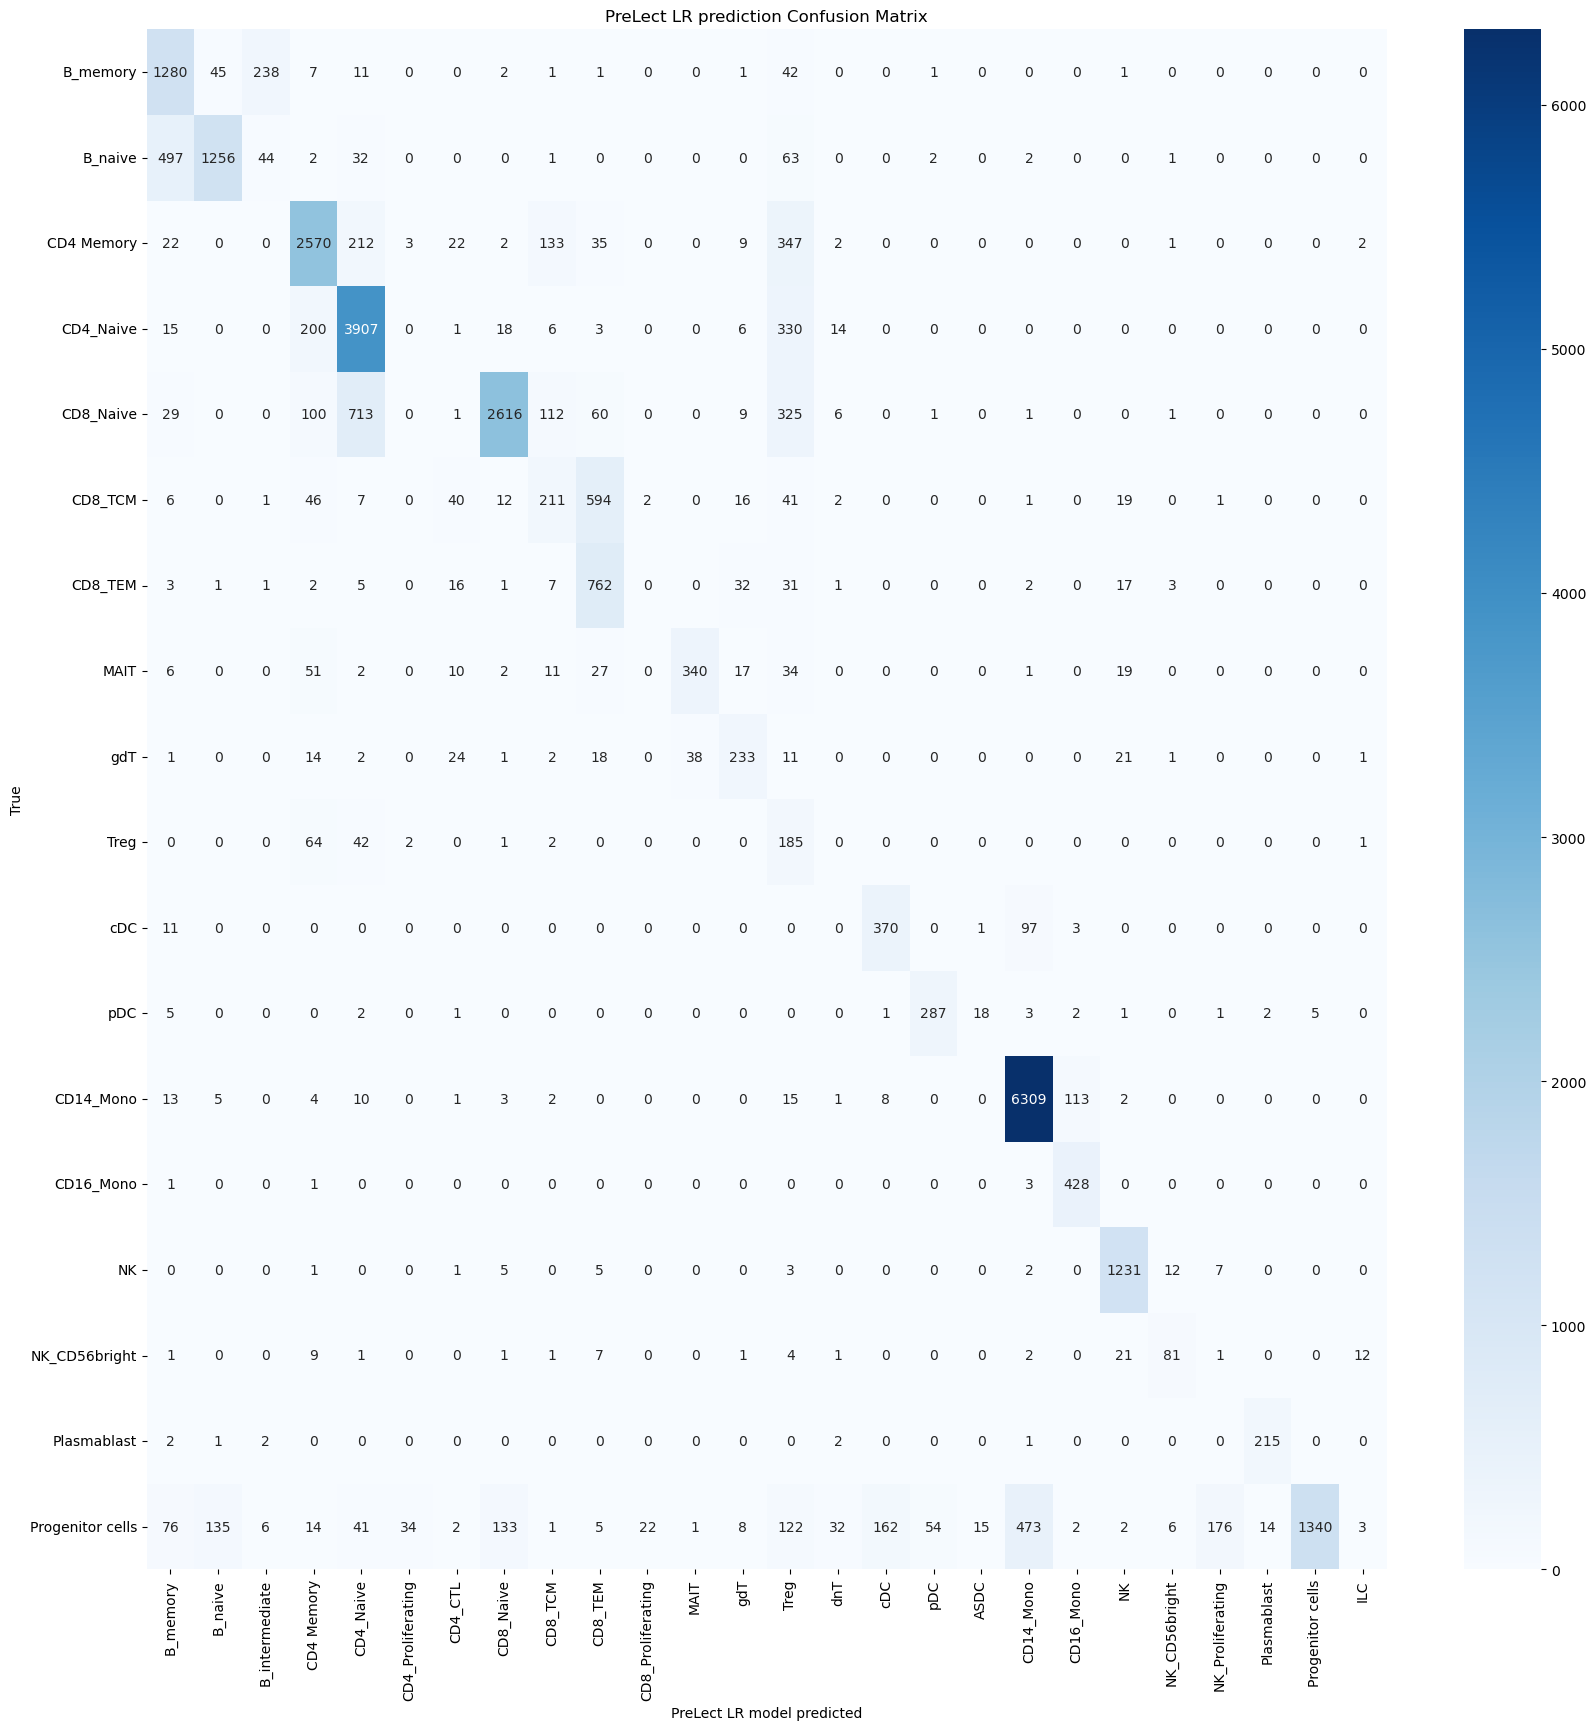

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('PreLect LR prediction Confusion Matrix')
plt.show()

In [38]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

method = ['micro', 'macro', 'weighted']
for m in method:
    precision = precision_score(true_labels, predicted_labels, average=m)
    print(f"{m} Precision:", precision)
    f1 = f1_score(true_labels, predicted_labels, average=m)
    print(f"{m} F1 Score:", f1)

Accuracy: 0.7701160667709963
micro Precision: 0.7701160667709963
micro F1 Score: 0.7701160667709963
macro Precision: 0.5211184639263682
macro F1 Score: 0.4987869194122046
weighted Precision: 0.8351921624052883
weighted F1 Score: 0.7836978403740762


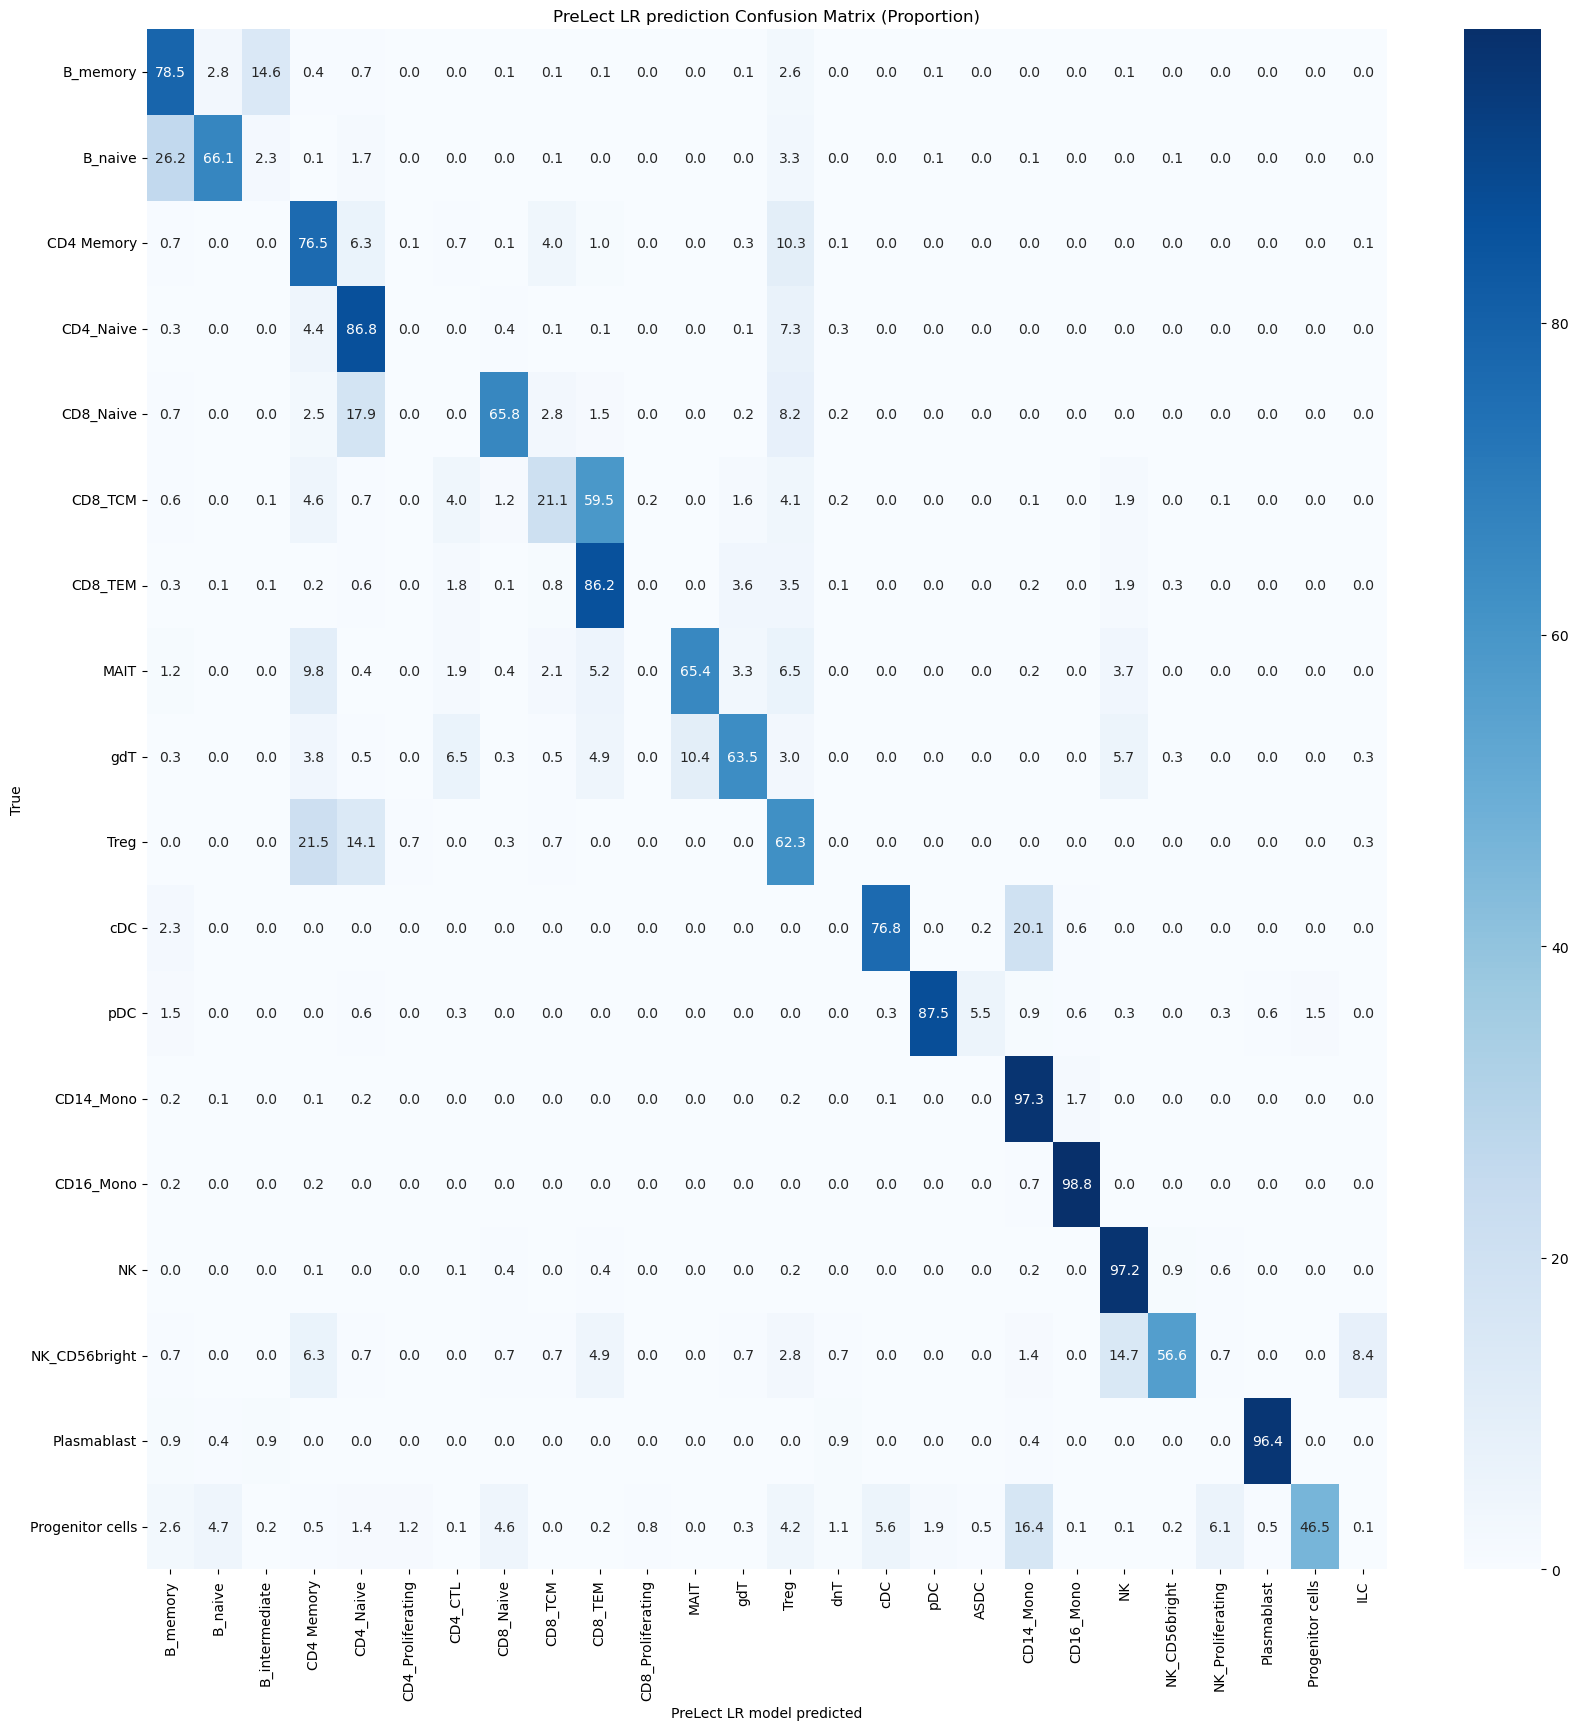

In [42]:
row_sum = cm.sum(axis=1)
cm_proportion = cm.div(row_sum, axis=0) * 100
plt.figure(figsize=(20, 20))
sns.heatmap(cm_proportion, annot=True, fmt='.1f', cmap='Blues')
plt.title('PreLect LR prediction Confusion Matrix (Proportion)')
plt.show()